In [1]:
%matplotlib inline
import scipy.io
from lab8_common import *
from pyqtgraph.Qt import QtGui, QtCore
import pyqtgraph as pg
import matplotlib.pyplot as plt
import random
import math
PI = math.pi

### Load Data

In [2]:
data_mat = scipy.io.loadmat('sensors.mat')
#Observations (actual noisy data)
observations = data_mat['sonars']
true_states = data_mat['true_states']

### Functions - Init, Propose, Likelihood, Resample 

In [3]:
def InitParticles(N):
    # return N weights with equal weights that sum to 1
    x = [random.random() for _ in range(0, N)]
    y = [random.random() for _ in range(0, N)]
    angle = np.random.uniform(0,2*PI, N)
    
    #particles 3 x N
    particles = np.ones((3,N))
    particles[0,:] = x
    particles[1,:] = y
    particles[2,:] = angle
    return particles

def Propose(samples):
    cov = [[.001, 0, 0], [0, .001, 0], [0, 0, .04]]
    mean = [0, 0, 0]
    
    step = np.random.multivariate_normal(mean, cov, N).T
    samples += step
    
    # clip new states to stay in map (between 0 and 1 values)
    samples[:2,:] = np.clip(samples[:2,:], 0, 1)
    return samples

def Resample(weights, particles, N):
    #Get new particles
    indices = np.random.choice([i for i in range(N)], p=weights[:,0], size=N)
    samples = particles[:,indices]
    
    #Forward Vector --> moved to propose step
    #samples[2,:] = np.random.uniform(0, 2*PI, N)
    return samples

def Laplacian(observations, particle_sensor_data, N):
    sigma = 1.0 / .026
    diff = np.absolute(observations - particle_sensor_data) #(10000,N)
    likelihood = np.exp(-1 * sigma * np.sum(diff, axis = 0))
    return likelihood.reshape(N,1)


#### Setup

In [4]:
N = 10000
weights = np.full((N, 1), (1.0/N))
room_map = create_map()
particles = InitParticles(N)

### Start Viewing Application

In [5]:
app = QtGui.QApplication( [] )
win = pg.GraphicsWindow( title="Particle filter" )
win.resize( 600, 600 )
win.setWindowTitle( 'Particle filter' )
pg.setConfigOptions( antialias=True )
 
p3 = win.addPlot( title="Room map" )

for i in range( 0, room_map.shape[0] ):
    p3.plot( [room_map[i,0], room_map[i,2]], [room_map[i,1], room_map[i,3]] )
p3.setXRange( -0.1, 1.1 )
p3.setYRange( -0.1, 1.1 ) 

pg.QtGui.QApplication.processEvents()

ts_plot=None
ex_plot=None

## Run Particle Filter

In [6]:
samples = particles
num_observations = observations.shape[1]
exs = np.zeros((3,num_observations))
for t in xrange(num_observations):
    #Propose
    samples = Propose(samples)
    
    #Expectation path
    exs[:,t] = np.mean(samples, axis=1)

    #Observations for Particles (Nx11)
    particle_sensor_data = cast_rays( samples, room_map )
    
    #Get Likelihoods (Nx1)
    likelihoods = Laplacian(observations[:,t:t+1], particle_sensor_data.T, N)
    
    #Update Weights using Likelihoods (Nx1)
    weights *= likelihoods

    #Normalize weights
    norm = np.sum(weights)
    weights /= float(norm)

    #Resample (3xN)
    samples = Resample(weights, samples, N)
    
    #Reset weights
    weights = np.full((N, 1), (1.0/N))
    
    #Plot Samples
    if ts_plot == None: 
        ts_plot = p3.plot( true_states[0,0:t+1], true_states[1,0:t+1], pen=(0,0,255) )
        ex_plot = p3.plot( exs[0,0:t+1], exs[1,0:t+1], pen=(0,255,0) )
        pts = p3.scatterPlot( samples[0,:], samples[1,:], symbol='o', size=1, pen=(255,100,100) )
    else:
        ts_plot.setData( true_states[0,0:t+1], true_states[1,0:t+1] )
        ex_plot.setData( exs[0,0:t+1], exs[1,0:t+1] )
        pts.setData( samples[0,:], samples[1,:] )
    
    pg.QtGui.QApplication.processEvents()

/Users/Iris/anaconda/lib/python2.7/site-packages/pyqtgraph/graphicsItems/ScatterPlotItem.py:186: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.atlasData[x:x+w, y:y+h] = rendered[key]
/Users/Iris/anaconda/lib/python2.7/site-packages/pyqtgraph/graphicsItems/ScatterPlotItem.py:148: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  arr = self.atlasData[x:x+w, y:y+w]
/Users/Iris/anaconda/lib/python2.7/site-packages/pyqtgraph/graphicsItems/ScatterPlotItem.py:183: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.atlasData = np.zeros((width, height, 4), dtype=np.ubyte)


# Final Frame

### Since the application runs outside of ipython notebook, here's a snaphot of the final image. You're welcome to run it all agian. This is stochastic, so it might not end up in the identical frame. 

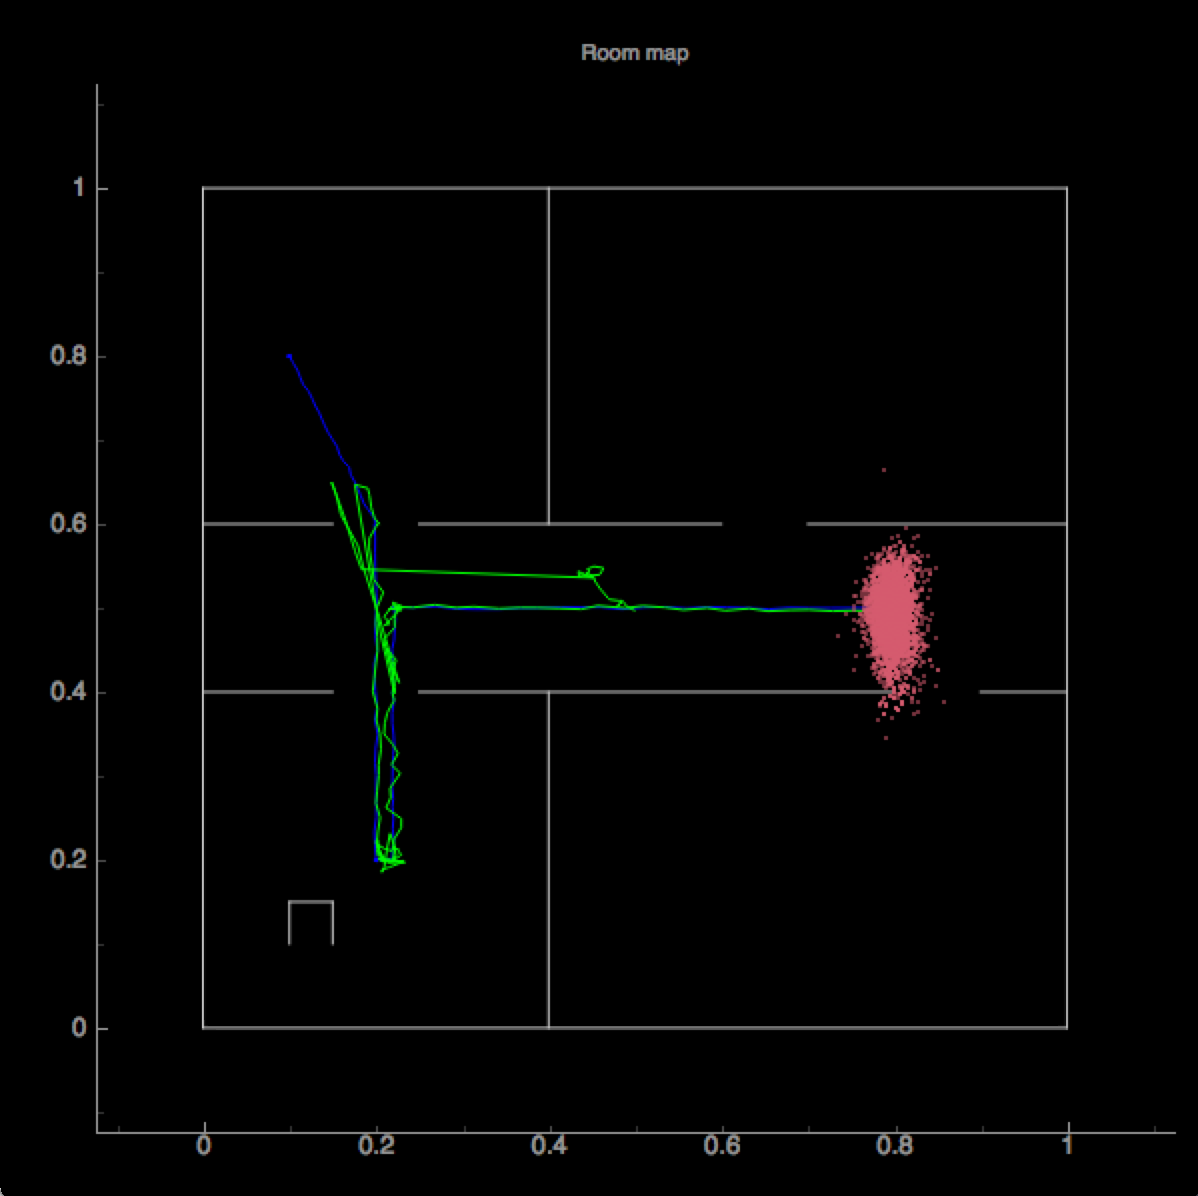

In [7]:
from IPython.display import Image 
Image(filename='final_snap_shot.png')